<a href="https://colab.research.google.com/github/lolatelo/open-street-collisions/blob/main/map_open_street_to_collisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
from pandas_gbq import to_gbq
import json
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

# Pull data from Bigquery

In [3]:
from google.colab import files
uploaded = files.upload()

Saving open-data-2024-78df73c35291.json to open-data-2024-78df73c35291 (1).json


In [4]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/open-data-2024-78df73c35291.json"


In [5]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

In [6]:
# Query to pull data from BigQuery
query = """
SELECT * FROM
`open-data-2024.nyc_motor_vechicle_crashes.collisions_with_coordinates`
where
(safe_cast(latitude as BIGNUMERIC)  > 40.477399 and  safe_cast(latitude as BIGNUMERIC) < 40.917577)
 and
 (safe_cast(longitude as BIGNUMERIC)  > -74.25909 and  safe_cast(longitude as BIGNUMERIC) < -73.700009)
"""
query_job = client.query(query)

# Store the data in a pandas DataFrame
collisions = query_job.to_dataframe()

In [7]:
# Query to pull data from BigQuery
query = """
SELECT * FROM
`open-data-2024.nyc_motor_vechicle_crashes.open_streets`
"""
query_job = client.query(query)

# Store the data in a pandas DataFrame
open_streets = query_job.to_dataframe()

# Map collisions to open_streets

In [8]:
# For collisions

collisions['geometry'] = collisions.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf_collisions = gpd.GeoDataFrame(collisions, geometry='geometry')

In [9]:
# For open streets
open_streets['geometry'] = open_streets.apply(lambda row: LineString([(row['longitude1'], row['latitude1']), (row['longitude2'], row['latitude2'])]), axis=1)
gdf_open_streets = gpd.GeoDataFrame(open_streets, geometry='geometry')
# Set CRS to WGS 84 (if your data is in latitude and longitude)
gdf_collisions.crs = "EPSG:4326"
gdf_open_streets.crs = "EPSG:4326"
print(gdf_collisions.crs)
print(gdf_open_streets.crs)

In [ ]:
# Assuming `gdf_collisions` is your GeoDataFrame and contains a 'borough' field
# # Convert 'latitude' and 'longitude' to floats
# collisions_filtered = collisions.copy()
# collisions_filtered['latitude'] = collisions_filtered['latitude'].astype(float)
# collisions_filtered['longitude'] = collisions_filtered['longitude'].astype(float)

# # Further filter out collisions with latitudes and longitudes outside NYC limits
# collisions_filtered = collisions_filtered[
#     (collisions_filtered['latitude'] > 40.477399) & (collisions_filtered['latitude'] < 40.917577) &
#     (collisions_filtered['longitude'] > -74.25909) & (collisions_filtered['longitude'] < -73.700009)
# ]

# # Convert the filtered DataFrame to a GeoDataFrame
# collisions_filtered['geometry'] = gpd.points_from_xy(collisions_filtered['longitude'], collisions_filtered['latitude'])
# gdf_collisions_filtered = gpd.GeoDataFrame(collisions_filtered, geometry='geometry')

In [11]:
# Create a buffer around open streets. Adjust the buffer size as needed.
gdf_open_streets_buffered = gdf_open_streets.copy()
gdf_open_streets_buffered['geometry'] = gdf_open_streets.geometry.buffer(0.0001)  # Example buffer size; adjust based on your needs

# Then perform the spatial join with the buffered GeoDataFrame
collisions_with_open_streets = gpd.sjoin(gdf_collisions, gdf_open_streets_buffered, how='left', op='intersects')


<ipython-input-11-6273ddbaeb20>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_open_streets_buffered['geometry'] = gdf_open_streets.geometry.buffer(0.0001)  # Example buffer size; adjust based on your needs
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [12]:
collisions_with_open_streets.appronstre.value_counts()

5 AVENUE           5600
3 AVENUE           2511
34 AVENUE          2229
COLUMBUS AVENUE    2164
BERRY STREET       1303
                   ... 
DEISIUS STREET        4
MURDOCK AVENUE        3
VERMONT COURT         2
EAST 161 STREET       1
NASSAU STREET         1
Name: appronstre, Length: 168, dtype: int64

In [13]:
collisions_with_open_streets['is_open_street'] = collisions_with_open_streets['index_right'].notnull()

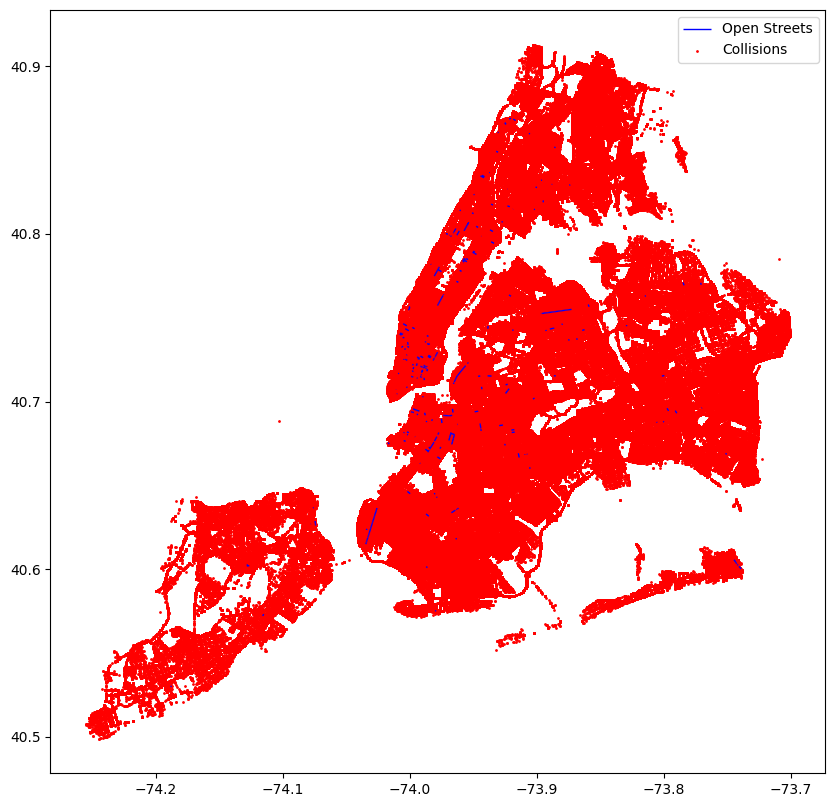

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_open_streets.plot(ax=ax, color='blue', linewidth=1, label='Open Streets')
#gdf_collisions.plot(ax=ax, color='red', markersize=1, label='Collisions')
plt.legend()
plt.show()


In [ ]:
open_streets.query("appronstre == '31 AVENUE'")

# apprdayswe = approved days of the week
#apprstartd = date that the open street started
#apprenddat = date that the open street ended
#apprsatope - hours; apprsatclo; apprsunope; apprsunclo

In [23]:
collisions_with_open_streets.columns

Index(['crash_date', 'crash_time', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'geometry',
       'index_right', 'object_id', 'orgname', 'appronstre', 'boroughname',
       'apprfromst', 'apprtostre', 'apprdayswe', 'reviewstat', 'apprmonope',
       'apprmonclo', 'apprtueope', 'apprtueclo', 'apprwedope', 'apprwedclo',
       'apprthuo

## Did the crash occur when the Open Street was in session?

To create a flag indicating whether a collision occurred while the open street was in session, follow these steps. This involves parsing dates and times, comparing them against the collision's timestamp, and taking the operational days and hours into account.

In [ ]:
"""
To create a flag indicating whether a collision occurred while the open street was in session, follow these steps. This involves parsing dates and times,
comparing them against the collision's timestamp, and taking the operational days and hours into account.
Step 1: Convert Date and Time Columns to DateTime Format
First, ensure that crash_date and crash_time are in an appropriate datetime format. Also, convert apprstartd and apprenddat to datetime.
"""
collisions_with_open_streets['crash_datetime'] = pd.to_datetime(collisions_with_open_streets['crash_date'] + ' ' + collisions_with_open_streets['crash_time'])

collisions_with_open_streets['apprstartd'] = pd.to_datetime(collisions_with_open_streets['apprstartd'])



In [27]:
collisions_with_open_streets['apprenddat'] = pd.to_datetime(collisions_with_open_streets['apprenddat'])

In [28]:
"""
Step 2: Define Function to Check If Crash Occurred During Open Street Session
This function will check:

If the crash date is within the operating period of the open street.
If the crash occurred on a day the open street operates.
If the crash time is within the operating hours for that day.
"""

def is_crash_during_open_street(row):
    # Check if crash date is within the open street operation period
    if not (row['apprstartd'] <= row['crash_datetime'].date() <= row['apprenddat']):
        return False

    # Dictionary to map day names to their corresponding operational time fields
    day_to_fields = {
        'mon': ('apprmonope', 'apprmonclo'),
        'tue': ('apprtueope', 'apprtueclo'),
        'wed': ('apprwedope', 'apprwedclo'),
        'thu': ('apprthuope', 'apprthuclo'),
        'fri': ('apprfriope', 'apprfriclo'),
        'sat': ('apprsatope', 'apprsatclo'),
        'sun': ('apprsunope', 'apprsunclo'),
    }

    # Get the day of the week from the crash datetime
    crash_day_of_week = row['crash_datetime'].strftime('%a').lower()

    # Check if the open street operates on this day of the week
    if crash_day_of_week in row['apprdayswe']:
        open_time_field, close_time_field = day_to_fields[crash_day_of_week]
        open_time_str = row[open_time_field]
        close_time_str = row[close_time_field]

        # Some rows may not have opening/closing time even if they operate on that day, assuming 24hrs operation
        if pd.isnull(open_time_str) or pd.isnull(close_time_str):
            return True

        # Convert open and close times to datetime.time for comparison
        open_time = pd.to_datetime(open_time_str, format='%H:%M').time()
        close_time = pd.to_datetime(close_time_str, format='%H:%M').time()

        # Check if crash time is within open hours
        if open_time <= row['crash_datetime'].time() <= close_time:
            return True

    return False



In [29]:
# Apply the function and create the flag
collisions_with_open_streets['crash_during_open_street'] = collisions_with_open_streets.apply(is_crash_during_open_street, axis=1)

<ipython-input-28-140d087c1edf>:12: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  if not (row['apprstartd'] <= row['crash_datetime'].date() <= row['apprenddat']):
<ipython-input-28-140d087c1edf>:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if not (row['apprstartd'] <= row['crash_datetime'].date() <= row['apprenddat']):


In [30]:
collisions_with_open_streets.crash_during_open_street.value_counts()

False    1837752
True         202
Name: crash_during_open_street, dtype: int64

# Analyzing
ok, let's start analyzing the data. write code that answers these questions:
1. how have motor vehicle crashes changed over time?
2. How have motor vehicle crashes changed on open street? During operation? At all hours?
3. How does time of day or time of year impact motor vehicle collisions? open streets are typically during the summer.

## How have motor vehicle crashes changed over time?

In [31]:
yearly_crashes = collisions_with_open_streets.resample('Y', on='crash_date').size()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

# Save to BigQuery

In [32]:
# SAVE OPEN STREET MAPPING TO BIGQUERY
collisions_with_open_streets['geometry'] = collisions_with_open_streets['geometry'].apply(lambda x: x.wkt)

# Ensure the rest of the DataFrame is in a format compatible with BigQuery
# This may involve converting other non-standard columns to string or appropriate formats

project_id = 'open-data-2024'
dataset_id = 'nyc_motor_vechicle_crashes'
table_id = 'collisions_with_open_streets' #UPDATE
table_full_name = f"{dataset_id}.{table_id}"

# Save the DataFrame to BigQuery
#UPDATE DF
collisions_with_open_streets.to_gbq(destination_table=table_full_name, project_id=project_id, if_exists='replace', progress_bar=True)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


ArrowTypeError: Expected a string or bytes dtype, got datetime64[ns]

In [42]:
collisions_with_open_streets.dtypes[collisions_with_open_streets.dtypes == 'datetime64[ns]']

apprstartd    datetime64[ns]
apprenddat    datetime64[ns]
dtype: object

In [43]:
# Convert to datetime only if they are not already datetime objects
collisions_with_open_streets['crash_date'] = pd.to_datetime(collisions_with_open_streets['crash_date'], errors='coerce')
collisions_with_open_streets['crash_datetime'] = pd.to_datetime(collisions_with_open_streets['crash_datetime'], errors='coerce')
collisions_with_open_streets['apprstartd'] = pd.to_datetime(collisions_with_open_streets['apprstartd'], errors='coerce')
collisions_with_open_streets['apprenddat'] = pd.to_datetime(collisions_with_open_streets['apprenddat'], errors='coerce')

# Assuming crash_time is a separate time column and not already part of crash_date
# If crash_time is not a time object but a string representing time, this step might need adjustment

collisions_with_open_streets['crash_date'] = collisions_with_open_streets['crash_date'].dt.strftime('%Y-%m-%d')
collisions_with_open_streets['crash_datetime'] = collisions_with_open_streets['crash_datetime'].dt.strftime('%Y-%m-%d')
collisions_with_open_streets['apprstartd'] = collisions_with_open_streets['apprstartd'].dt.strftime('%Y-%m-%d')
collisions_with_open_streets['apprenddat'] = collisions_with_open_streets['apprenddat'].dt.strftime('%Y-%m-%d')

project_id = 'open-data-2024'
dataset_id = 'nyc_motor_vechicle_crashes'
table_id = 'collisions_with_open_streets' #UPDATE
table_full_name = f"{dataset_id}.{table_id}"

# Save the DataFrame to BigQuery
#UPDATE DF
collisions_with_open_streets.to_gbq(destination_table=table_full_name, project_id=project_id, if_exists='replace', progress_bar=True)

100%|██████████| 1/1 [00:00<00:00, 1107.55it/s]


# Next steps
* EDA in Data Studio
* Think through model and web app